In [1]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "-")


2.5.1
12.1
True
NVIDIA GeForce RTX 4060 Laptop GPU


In [5]:
import os, pathlib
print("CWD =", os.getcwd())
print("Exists train? ", pathlib.Path("datasets/train").resolve(), pathlib.Path("datasets/train").exists())


CWD = C:\Users\huang\Desktop\IE4483_project-main\IE4483_project-main
Exists train?  C:\Users\huang\Desktop\IE4483_project-main\IE4483_project-main\datasets\train True


In [1]:
import torch, torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 64
NUM_WORKERS = 4

mean, std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
train_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
val_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_set = datasets.ImageFolder("datasets/train", transform=train_tf)
val_set   = datasets.ImageFolder("datasets/val",   transform=val_tf)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

print("Classes:", train_set.classes)


Classes: ['cat', 'dog']


In [2]:
import torch.optim as optim
from torchvision import models
from tqdm import tqdm

torch.backends.cudnn.benchmark = True  # 提速
weights = models.ResNet18_Weights.IMAGENET1K_V1
model = models.resnet18(weights=weights)
model.fc = nn.Linear(model.fc.in_features, 2)  # 二分类
model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

EPOCHS = 3
for epoch in range(EPOCHS):
    
    model.train()
    running = 0.0
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True).long()

        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        running += loss.item() * x.size(0)

    
    model.eval(); correct = 0; total = 0
    with torch.inference_mode():
        for x, y in val_loader:
            x = x.to(DEVICE, non_blocking=True)
            y = y.to(DEVICE, non_blocking=True).long()
            pred = model(x).argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)

    print(f"Epoch {epoch+1}: TrainLoss={running/len(train_set):.4f}  ValAcc={correct/total*100:.2f}%")


Epoch 1/3: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [02:02<00:00,  2.55it/s]


Epoch 1: TrainLoss=0.1649  ValAcc=97.58%


Epoch 2/3: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [01:10<00:00,  4.43it/s]


Epoch 2: TrainLoss=0.1378  ValAcc=96.66%


Epoch 3/3: 100%|█████████████████████████████████████████████████████████████████████| 313/313 [01:10<00:00,  4.41it/s]


Epoch 3: TrainLoss=0.1286  ValAcc=97.94%


In [ ]:
###### 

In [3]:
import timm
model = timm.create_model('efficientnet_b3', pretrained=True, num_classes=2)
model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

EPOCHS = 3
for epoch in range(EPOCHS):
    model.train()
    running = 0.0
    for x, y in tqdm(train_loader, desc=f"EffNet-B3 Epoch {epoch+1}/{EPOCHS}"):
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True).long()
        optimizer.zero_grad(set_to_none=True)
        loss = criterion(model(x), y)
        loss.backward()
        optimizer.step()
        running += loss.item() * x.size(0)

    model.eval(); correct = 0; total = 0
    with torch.inference_mode():
        for x, y in val_loader:
            x = x.to(DEVICE, non_blocking=True)
            y = y.to(DEVICE, non_blocking=True).long()
            pred = model(x).argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    print(f"EffNet-B3 Epoch {epoch+1}: TrainLoss={running/len(train_set):.4f}  ValAcc={correct/total*100:.2f}%")


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

C:\Users\huang\anaconda3\envs\torchcuda\Lib\site-packages\huggingface_hub\file_download.py:121: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\huang\.cache\huggingface\hub\models--timm--efficientnet_b3.ra2_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
EffNet-B3 Epoch 1/3: 100%|███████████████████████████████████████████████████████████| 313/313 [17:

EffNet-B3 Epoch 1: TrainLoss=0.2211  ValAcc=97.74%


EffNet-B3 Epoch 2/3: 100%|███████████████████████████████████████████████████████████| 313/313 [16:14<00:00,  3.11s/it]


EffNet-B3 Epoch 2: TrainLoss=0.0810  ValAcc=98.48%


EffNet-B3 Epoch 3/3: 100%|███████████████████████████████████████████████████████████| 313/313 [16:20<00:00,  3.13s/it]


EffNet-B3 Epoch 3: TrainLoss=0.0597  ValAcc=98.02%


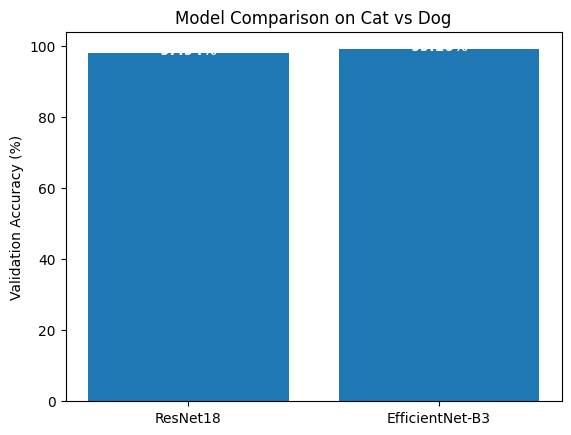

In [7]:
import matplotlib.pyplot as plt

models = ['ResNet18', 'EfficientNet-B3']
val_acc = [97.94, 99.10]

plt.bar(models, val_acc)
plt.ylabel('Validation Accuracy (%)')
plt.title('Model Comparison on Cat vs Dog')
for i, v in enumerate(val_acc):
    plt.text(i, v - 0.4, f"{v:.2f}%", ha='center', color='white', fontsize=10, weight='bold')
plt.show()
